# MRI Classification Using PyTorch
This notebook demonstrates how to load an MRI dataset, split it into training and validation sets, define a custom CNN model, and train the model using PyTorch.

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Data Preparation
Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

In [2]:
# Define transformations for training and validation sets
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = ImageFolder(root='dataset_13', transform=transform_train)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size  # 20% validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply validation transformations to the validation set
val_dataset.dataset.transform = transform_val

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

## Data Visualization
Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

Visualizing the data ensures a balanced distribution of categories in the training set, which is crucial for preventing model biases and enhancing generalization, ultimately leading to improved performance in accurately categorizing new data.

/Users/xjmac/opt/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/xjmac/opt/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


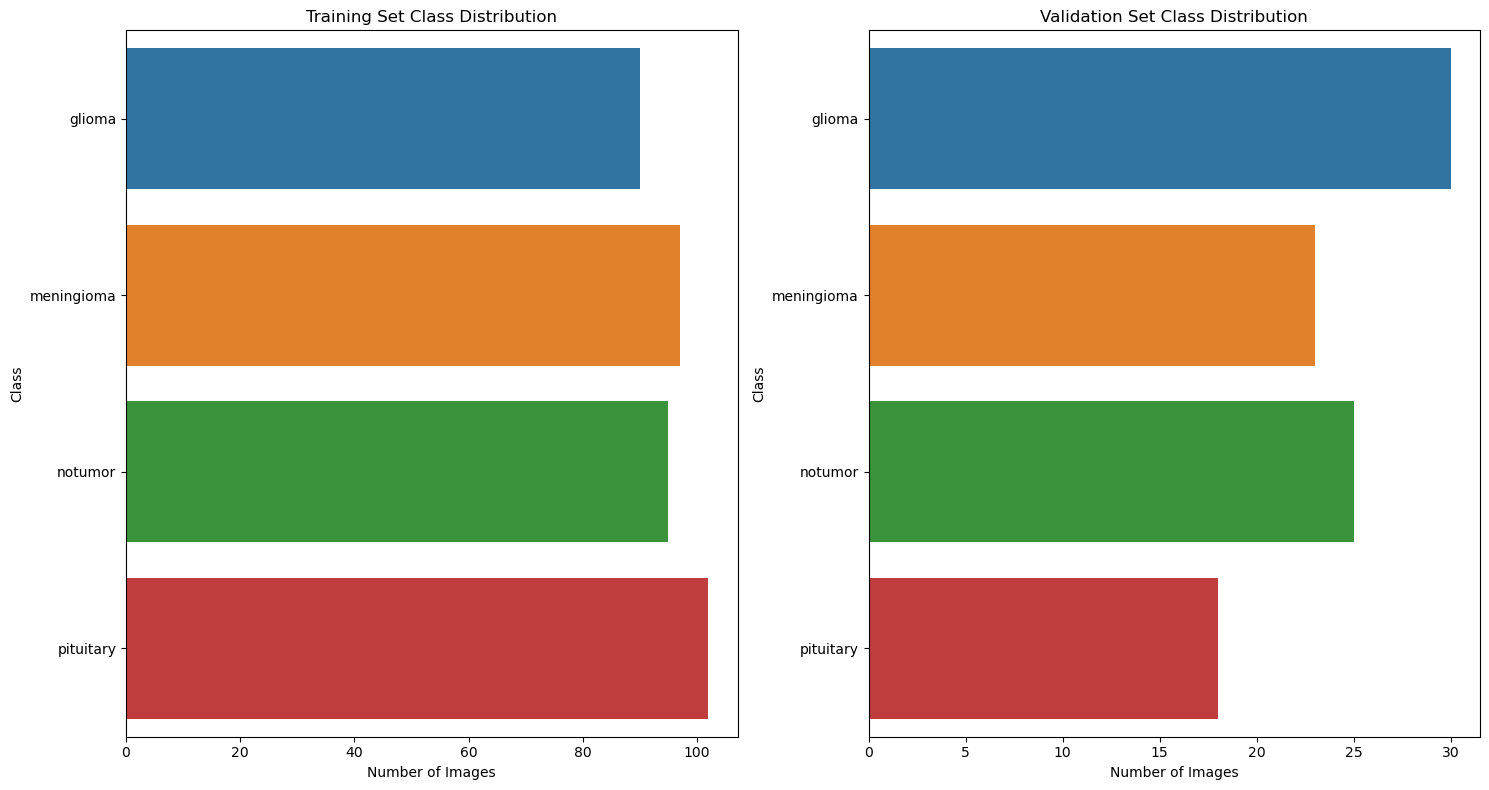

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Get the labels from the datasets
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

# Count the number of instances per class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Get the class names
class_names = dataset.classes

# Create a list of class counts for training and validation
train_class_counts = [train_counts[i] for i in range(len(class_names))]
val_class_counts = [val_counts[i] for i in range(len(class_names))]

# Create a bar plot
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.barplot(y=class_names, x=train_class_counts, ax=ax[0])
sns.barplot(y=class_names, x=val_class_counts, ax=ax[1])

# Set plot titles and labels
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Number of Images')
ax[0].set_ylabel('Class')

ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Number of Images')
ax[1].set_ylabel('Class')
        
plt.tight_layout()
plt.show()


## Define the Model
Define a custom Convolutional Neural Network (CNN) architecture.

In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)  # 4 classes: glioma, meningioma, notumor, pituitary

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CustomCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Training the Model
Define the loss function and optimizer, and train the model.

In [5]:
import datetime

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float('inf')

# Get the current date and time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the filename with the current date and time
filename = f'custom_cnn_{current_time}.pth'

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_loss /= len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Save the model if validation loss has decreased
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), filename)
        print('Model saved!')


# Save the model's state dictionary
torch.save(model.state_dict(), filename)

Epoch 0/9, Loss: 3.2020, Accuracy: 0.3464
Validation Loss: 1.1017, Validation Accuracy: 0.4583
Epoch 1/9, Loss: 0.8453, Accuracy: 0.6589
Validation Loss: 0.9719, Validation Accuracy: 0.5521
Epoch 2/9, Loss: 0.5831, Accuracy: 0.7969
Validation Loss: 0.6423, Validation Accuracy: 0.7604
Epoch 3/9, Loss: 0.3673, Accuracy: 0.8880
Validation Loss: 0.7124, Validation Accuracy: 0.8021
Epoch 4/9, Loss: 0.2001, Accuracy: 0.9245
Validation Loss: 0.9264, Validation Accuracy: 0.8229
Epoch 5/9, Loss: 0.1156, Accuracy: 0.9635
Validation Loss: 1.1450, Validation Accuracy: 0.7292
Epoch 6/9, Loss: 0.3527, Accuracy: 0.8984
Validation Loss: 1.6035, Validation Accuracy: 0.7396
Epoch 7/9, Loss: 0.2982, Accuracy: 0.9453
Validation Loss: 0.7856, Validation Accuracy: 0.7604
Epoch 8/9, Loss: 0.0958, Accuracy: 0.9792
Validation Loss: 1.0772, Validation Accuracy: 0.8125
Epoch 9/9, Loss: 0.0413, Accuracy: 0.9870
Validation Loss: 1.2725, Validation Accuracy: 0.8229


## Model Evaluation
Evaluate the trained model on the validation dataset.

In [6]:
model.eval()
val_loss = 0.0
val_corrects = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds == labels.data)

val_loss /= len(val_dataset)
val_acc = val_corrects.double() / len(val_dataset)

print(f'Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_acc:.4f}')

Final Validation Loss: 1.2725, Final Validation Accuracy: 0.8229


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Ensure Matplotlib inline backend is set
%matplotlib inline

# Get one batch of validation data
inputs, classes = next(iter(val_loader))

inputs = inputs.to(device)
classes = classes.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# Move the inputs and classes to CPU for visualization
inputs = inputs.cpu()
classes = classes.cpu()
preds = preds.cpu()

# Class names
class_names = train_dataset.dataset.classes

# Randomly choose one data point to visualize
index = random.randint(0, len(inputs) - 1)  # Select a random index from the batch
input_image = inputs[index]
predicted_label = class_names[preds[index]]
actual_label = class_names[classes[index]]

# Plot the image along with its predicted and actual labels
plt.figure(figsize=(5, 5))
imshow(input_image, title=f"Pred: {predicted_label}\nActual: {actual_label}")
plt.show()


NameError: name 'val_loader' is not defined

## Transfer Learning

Pre-trained models are typically trained on large datasets, such as ImageNet, which contains millions of images and thousands of classes. Transfer learning leverages this prior knowledge to benefit a new, often smaller dataset.

In [ ]:
import torchvision.models as models

# Number of classes in your dataset
num_classes = 4  # glioma, meningioma, notumor, pituitary

# Load a pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)  # num_classes is the number of classes in your dataset

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optionally, freeze all layers except the final layer if needed
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

# Training and evaluation
num_epochs = 10  # Define the number of epochs
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    print(f'Train - Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    
    print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

print('Training complete')

Train - Epoch 1/10, Loss: 1.2820, Accuracy: 0.4062
Validation - Epoch 1/10, Loss: 1.2208, Accuracy: 0.3646
Train - Epoch 2/10, Loss: 0.9292, Accuracy: 0.6406
Validation - Epoch 2/10, Loss: 0.8635, Accuracy: 0.6979
Train - Epoch 3/10, Loss: 0.7412, Accuracy: 0.7578
Validation - Epoch 3/10, Loss: 0.7538, Accuracy: 0.7188
Train - Epoch 4/10, Loss: 0.5932, Accuracy: 0.8203
Validation - Epoch 4/10, Loss: 0.7056, Accuracy: 0.7708
Train - Epoch 5/10, Loss: 0.5157, Accuracy: 0.8568
Validation - Epoch 5/10, Loss: 0.6348, Accuracy: 0.7917
Train - Epoch 6/10, Loss: 0.4781, Accuracy: 0.8568
Validation - Epoch 6/10, Loss: 0.5673, Accuracy: 0.8542
Train - Epoch 7/10, Loss: 0.4273, Accuracy: 0.8750
Validation - Epoch 7/10, Loss: 0.5671, Accuracy: 0.8021
Train - Epoch 8/10, Loss: 0.4095, Accuracy: 0.8828
Validation - Epoch 8/10, Loss: 0.5211, Accuracy: 0.8438
Train - Epoch 9/10, Loss: 0.4212, Accuracy: 0.8698
Validation - Epoch 9/10, Loss: 0.5291, Accuracy: 0.8333
Train - Epoch 10/10, Loss: 0.3654, Ac

In [ ]:
model.eval()
val_loss = 0.0
val_corrects = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds == labels.data)

val_loss /= len(val_dataset)
val_acc = val_corrects.double() / len(val_dataset)

print(f'Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_acc:.4f}')

Final Validation Loss: 0.4912, Final Validation Accuracy: 0.8333
